# SETTINGS

This notebooks imports the processed data `df.csv` and `df_test.csv` generated in `notebook_02_features.ipynb`. 

The notebook implements meta-parameter tuning to find values maximizing the profit. The resulting values are then used in `notebook_03_modeling.ipynb`.

A detailed walkthrough of the code covering the key steps is provided in [this blog post](https://kozodoi.me/python/time%20series/demand%20forecasting/competitions/2020/07/27/demand-forecasting.html).

In [1]:
########## LIBRARIES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import os
import time
import datetime
import random
import multiprocessing
import pickle
import warnings
import gc
from tqdm import tqdm
import importlib

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

In [2]:
########## SETTINGS

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')
%matplotlib inline
gc.enable()

# DATA IMPORT

In [3]:
# read data
df_train = pd.read_csv('../data/prepared/df_v12.csv',      compression = 'gzip')
df_test  = pd.read_csv('../data/prepared/df_test_v12.csv', compression = 'gzip')
print(df_train.shape)
print(df_test.shape)
df_train.head()

(1454357, 80)
(10463, 80)


,day_of_year,days_since_last_order,itemID,mean_price_test,order_all_count_last_14,order_all_count_last_21,order_all_count_last_28,order_all_count_last_7,order_all_sum_last_14,order_all_sum_last_21,order_all_sum_last_28,order_all_sum_last_7,order_category_count_last_14,order_category_count_last_21,order_category_count_last_28,order_category_count_last_7,order_category_sum_last_14,order_category_sum_last_21,order_category_sum_last_28,order_category_sum_last_7,order_count_last_14,order_count_last_21,order_count_last_28,order_count_last_7,order_manufacturer_count_last_14,order_manufacturer_count_last_21,order_manufacturer_count_last_28,order_manufacturer_count_last_7,order_manufacturer_sum_last_14,order_manufacturer_sum_last_21,order_manufacturer_sum_last_28,order_manufacturer_sum_last_7,order_sum_last_14,order_sum_last_21,order_sum_last_28,order_sum_last_7,promo_all_count_last_14,promo_all_count_last_21,promo_all_count_last_28,promo_all_count_last_7,promo_category_count_last_14,promo_category_count_last_21,promo_category_count_last_28,promo_category_count_last_7,promo_count_last_14,promo_count_last_21,promo_count_last_28,promo_count_last_7,promo_in_test,promo_in_test_category,promo_in_test_manufacturer,promo_manufacturer_count_last_14,promo_manufacturer_count_last_21,promo_manufacturer_count_last_28,promo_manufacturer_count_last_7,target,ratio_mean_price_last_7,ratio_manufacturer_mean_price_last_7,ratio_category_mean_price_last_7,ratio_mean_price_last_14,ratio_manufacturer_mean_price_last_14,ratio_category_mean_price_last_14,ratio_mean_price_last_21,ratio_manufacturer_mean_price_last_21,ratio_category_mean_price_last_21,ratio_mean_price_last_28,ratio_manufacturer_mean_price_last_28,ratio_category_mean_price_last_28,simulationPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,recommended_simulation_price_ratio,category,customerRating_manufacturer_ratio,customerRating_category_ratio
0,28,3.0,1,3.0,4152,6056,7887,2006,113336,162585,212623,56544,273,372,465,109,6116,8201,10701,739,2,2,2,2,12,15,18,6,64,67,71,30,2,2,2,2,620.0,822.0,1048.0,305.0,51.0,67.0,79.0,11.0,0.0,0.0,0.0,0.0,1.0,48.0,11.0,2.0,2.0,2.0,1.0,314.0,1.0,13.723810,74.369506,1.000000,13.723810,74.369506,1.000000,13.723810,74.369506,1.000000,13.723810,74.369506,3.43,NaN,1,4.38,1,1,1,8.84,0.388009,111,0.933902,0.964857
1,28,28.0,2,9.0,4152,6056,7887,2006,113336,162585,212623,56544,15,22,32,4,269,429,875,18,0,0,0,0,186,239,295,59,3579,3845,4138,119,0,0,0,0,620.0,822.0,1048.0,305.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23.0,37.0,40.0,44.0,3.0,0.0,1.0,4.125451,3.359410,1.000000,4.125451,3.359410,1.000000,4.125451,3.359410,1.000000,4.125451,3.359410,9.15,NaN,2,3.00,1,2,1,16.92,0.540780,121,0.648909,0.675458
2,28,2.0,3,14.0,4152,6056,7887,2006,113336,162585,212623,56544,58,74,88,27,1548,1614,2009,542,6,7,7,4,33,50,66,16,602,635,652,22,95,96,96,4,620.0,822.0,1048.0,305.0,16.0,17.0,18.0,7.0,1.0,1.0,1.0,0.0,1.0,8.0,23.0,4.0,4.0,4.0,0.0,90.0,1.0,2.392567,11.048971,1.113636,2.664449,12.304536,1.072993,2.567207,11.855465,1.053763,2.521199,11.643002,14.04,NaN,3,5.00,1,3,1,15.89,0.883575,131,1.082351,1.076899
3,28,10.0,4,13.0,4152,6056,7887,2006,113336,162585,212623,56544,15,22,32,4,269,429,875,18,1,1,1,0,186,239,295,59,3579,3845,4138,119,1,1,1,0,620.0,822.0,1048.0,305.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23.0,37.0,40.0,44.0,3.0,0.0,1.0,2.856081,2.325745,1.000000,2.856081,2.325745,1.000000,2.856081,2.325745,1.000000,2.856081,2.325745,14.10,NaN,2,4.44,1,2,1,40.17,0.351008,121,0.960385,0.999678
4,28,7.0,5,7.0,4152,6056,7887,2006,113336,162585,212623,56544,273,372,465,109,6116,8201,10701,739,1,1,3,0,186,239,295,59,3579,3845,4138,119,1,1,3,0,620.0,822.0,1048.0,305.0,51.0,67.0,79.0,11.0,0.0,0.0,0.0,0.0,0.0,48.0,23.0,37.0,40.0,44.0,3.0,0.0,1.0,5.304151,31.872645,1.000000,5.304151,31.872645,1.000000,5.304151,31.872645,1.000000,5.304151,31.872645,7.48,NaN,2,2.33,1,1,1,17.04,0.438967,111,0.503986,0.513269


In [4]:
# extract target
y = df_train['target']
X = df_train.drop('target', axis = 1)
del df_train
print(X.shape, y.shape)

# format test data
X_test = df_test.drop('target', axis = 1)
del df_test
print(X_test.shape)

(1454357, 79) (1454357,)
(10463, 79)


In [5]:
# read items
items = pd.read_csv('../data/prepared/items_v1.csv', compression = 'gzip')
print(items.shape)

# keep existing IDs
items = items[items['itemID'].isin(X['itemID'].unique())]
print(items.shape)

(10463, 12)
(10463, 12)


# PARAMETER TUNING

In [6]:
##### IMPORT EVALUATION FUNCTIUONS

# profit function
import functions
importlib.reload(functions)
from functions import asymmetric_mse, profit, postprocess_preds

In [7]:
##### LIST RELEVANT FEATURES

drop_feats = ['itemID', 'day_of_year'] + ['category1', 'category2', 'category3'] #+ list(X.filter(like = '_all_).columns
features = [var for var in X.columns if var not in drop_feats]
print(len(features), 'features')
features

74 features


['days_since_last_order',
 'mean_price_test',
 'order_all_count_last_14',
 'order_all_count_last_21',
 'order_all_count_last_28',
 'order_all_count_last_7',
 'order_all_sum_last_14',
 'order_all_sum_last_21',
 'order_all_sum_last_28',
 'order_all_sum_last_7',
 'order_category_count_last_14',
 'order_category_count_last_21',
 'order_category_count_last_28',
 'order_category_count_last_7',
 'order_category_sum_last_14',
 'order_category_sum_last_21',
 'order_category_sum_last_28',
 'order_category_sum_last_7',
 'order_count_last_14',
 'order_count_last_21',
 'order_count_last_28',
 'order_count_last_7',
 'order_manufacturer_count_last_14',
 'order_manufacturer_count_last_21',
 'order_manufacturer_count_last_28',
 'order_manufacturer_count_last_7',
 'order_manufacturer_sum_last_14',
 'order_manufacturer_sum_last_21',
 'order_manufacturer_sum_last_28',
 'order_manufacturer_sum_last_7',
 'order_sum_last_14',
 'order_sum_last_21',
 'order_sum_last_28',
 'order_sum_last_7',
 'promo_all_count_

In [8]:
########## MODELING PARAMETERS

### TRAINING OPTIONS

# target transformation
target_transform = True

# train on positive sales only
train_on_positive = False


### TUNING PARAMETERS

# trials
tuning_trials = 100


### CLASSIFIER PARAMETERS

# boosting types
boost_types = ['gbdt', 'goss']

# training params
lgb_reg_params = {    
    'boosting_type':    hp.choice('boosting_type', boost_types),    
    'objective':        'rmse',
    'metrics':          'rmse',
    'n_estimators':     10000,
    'learning_rate':    hp.uniform('learning_rate',  0.0001, 0.3),
    'max_depth':        hp.quniform('max_depth',          1,  16, 1),
    'num_leaves':       hp.quniform('num_leaves',        10,  64, 1),
    'bagging_fraction': hp.uniform('bagging_fraction',  0.3,   1),
    'feature_fraction': hp.uniform('feature_fraction',  0.3,   1),
    'lambda_l1':        hp.uniform('lambda_l1',           0,   1),
    'lambda_l2':        hp.uniform('lambda_l2',           0,   1),
    'silent':           True,
    'verbosity':        -1,
    'nthread' :         4,
    'random_state':     77,
}

# evaluation params
lgb_fit_params = {
    'eval_metric':           'rmse',
    'early_stopping_rounds': 100,
    'verbose':               False,
}

# combine params
lgb_space = dict()
lgb_space['reg_params'] = lgb_reg_params
lgb_space['fit_params'] = lgb_fit_params

In [9]:
##### HYPEROPT OBJECT

class HPOpt(object):

    # INIT
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    # optimization process
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn        = fn, 
                          space     = space, 
                          algo      = algo, 
                          max_evals = max_evals, 
                          trials    = trials)
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        return result, trials
    
    
    # LGBM INITIALIZATION
    def lgb_reg(self, para):
        para['reg_params']['max_depth']  = int(para['reg_params']['max_depth'])
        para['reg_params']['num_leaves'] = int(para['reg_params']['num_leaves'])
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    
    # TRAINING AND INFERENCE
    def train_reg(self, reg, para):
        
        # fit LGB
        reg.fit(self.x_train, self.y_train,
                eval_set              = [(self.x_train, self.y_train), (self.x_test, self.y_test)], 
                sample_weight         = self.x_train['simulationPrice'].values,
                eval_sample_weight    = [self.x_train['simulationPrice'].values, self.x_test['simulationPrice'].values],
                **para['fit_params'])
        
        # inference
        if target_transform:      
            preds = postprocess_preds(reg.predict(self.x_test)**2)
            reals = self.y_test**2
        else:
            preds = postprocess_preds(reg.predict(self.x_test))
            reals = self.y_test
        
        # impute zeros
        if train_on_positive:
            preds[(self.x_test['order_sum_last_28'] == 0) & (self.x_test['promo_in_test'] == 0)] = 0

        # compute loss [negative profit]
        loss = np.round(-profit(reals, preds, price = self.x_test['simulationPrice'].values))
                      
        return {'loss': loss, 'status': STATUS_OK}

In [10]:
##### DATA PARTITIONING

# validation dates
v_end   = 158          # 1 day before last validation fold in code_03_modeling
v_start = v_end        # same as v_start

# training dates
t_start = 28           # first day in the data
t_end   = v_start - 15 # validation day - two weeks

# extract index
train_idx = list(X[(X.day_of_year >= t_start) & (X.day_of_year <= t_end)].index)
valid_idx = list(X[(X.day_of_year >= v_start) & (X.day_of_year <= v_end)].index)   

# extract samples
X_train, y_train = X.iloc[train_idx][features], y.iloc[train_idx]
X_valid, y_valid = X.iloc[valid_idx][features], y.iloc[valid_idx]

# keep positive cases
if train_on_positive:
    y_train = y_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]
    X_train = X_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]
    
# target transformation
if target_transform:
    y_train = np.sqrt(y_train)
    y_valid = np.sqrt(y_valid)

# information
print('-' * 65)
print('- train period days: {} -- {} (n = {})'.format(t_start, t_end, len(train_idx)))
print('- valid period days: {} -- {} (n = {})'.format(v_start, v_end, len(valid_idx)))
print('-' * 65)

-----------------------------------------------------------------
- train period days: 28 -- 143 (n = 1213708)
- valid period days: 158 -- 158 (n = 10463)
-----------------------------------------------------------------


In [11]:
##### PARAMETER TUNING

# instantiate objects
hpo_obj = HPOpt(X_train, X_valid, y_train, y_valid)
trials  = Trials() 

# perform tuning
lgb_opt_params = hpo_obj.process(fn_name   = 'lgb_reg',
                                 space     = lgb_space, 
                                 trials    = trials, 
                                 algo      = tpe.suggest, 
                                 max_evals = tuning_trials)  

100%|██████████| 100/100 [3:07:35<00:00, 112.56s/trial, best loss: -3997707.0] 


In [12]:
# merge best params to fixed params
params = list(lgb_opt_params[0].keys())
for par_id in range(len(params)):
    lgb_reg_params[params[par_id]] = lgb_opt_params[0][params[par_id]]
    
# postprocess
lgb_reg_params['boosting_type'] = boost_types[lgb_reg_params['boosting_type']]
lgb_reg_params['max_depth']     = int(lgb_reg_params['max_depth'])
lgb_reg_params['num_leaves']    = int(lgb_reg_params['num_leaves'])

# RESULTS

In [13]:
# print best params
print('Best meta-parameters:')
lgb_reg_params

Best meta-parameters:


{'boosting_type': 'goss',
 'objective': 'rmse',
 'metrics': 'rmse',
 'n_estimators': 10000,
 'learning_rate': 0.004012417857266637,
 'max_depth': 10,
 'num_leaves': 64,
 'bagging_fraction': 0.9346881591116736,
 'feature_fraction': 0.6680768850934483,
 'lambda_l1': 0.28013320828944976,
 'lambda_l2': 0.5896826524767101,
 'silent': True,
 'verbosity': -1,
 'nthread': 4,
 'random_state': 77}

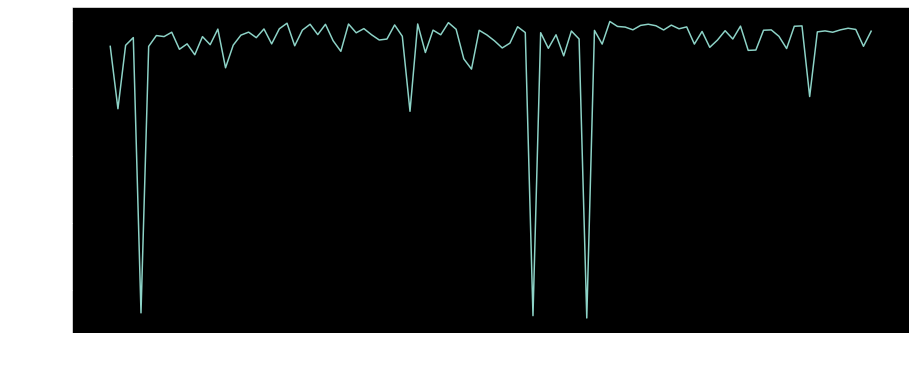

In [14]:
##### LOSS DYNAMICS

# extract loss
y = [-x['loss'] for x in trials.results]

# plot results
fig = plt.figure(figsize = (15, 6))
plt.plot(range(1, len(y) + 1), y)
plt.ylabel('Profit')
plt.xlabel('Iteration')
plt.savefig('../lgb_meta_params_loss.pdf')

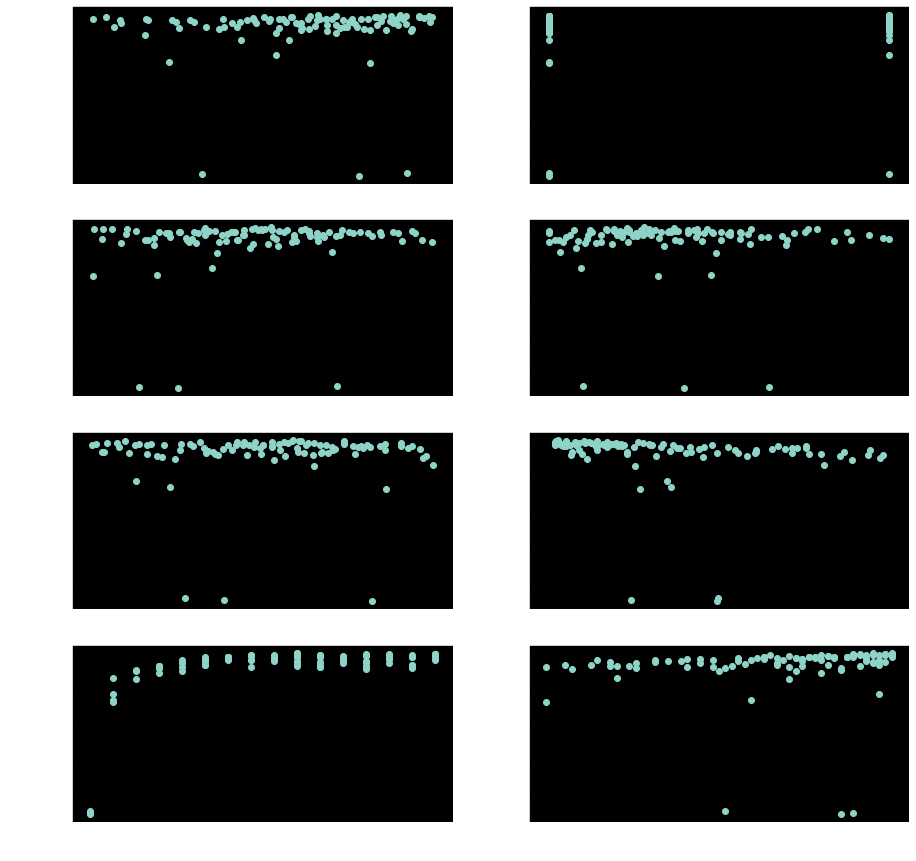

In [15]:
##### PARAMETER PLOTS

# plot relationships
meta_params = list(trials.vals.keys())
fig = plt.figure(figsize = (15, 15))
for i in range(len(meta_params)):
    
    # extract values and loss
    x = trials.vals[meta_params[i]]
    y = [-x['loss'] for x in trials.results]
        
    # plot results
    plt.subplot(4, 2, i + 1)
    plt.scatter(x, y)
    plt.xlabel(meta_params[i])
    if (i == 0) | (i == 3):
        plt.ylabel('Profit')
    
# export PDF
plt.savefig('../lgb_meta_params_plots.pdf')

In [16]:
# export dictionary
par_file = open('../lgb_meta_params.pkl', 'wb')
pickle.dump(lgb_reg_params, par_file)
par_file.close()